# 3. cas: PDFs

Ex 1: Let’s take a look at the simple example. We have distribution function and we should find the probability of falling in the interval between a and b. This probability is simply area lying under the curve from a to b. In order to find definite integral, we will use a "magic" function from numerical analysis domain:

probability to fall between 1 and 3 : 0.18219431204637548


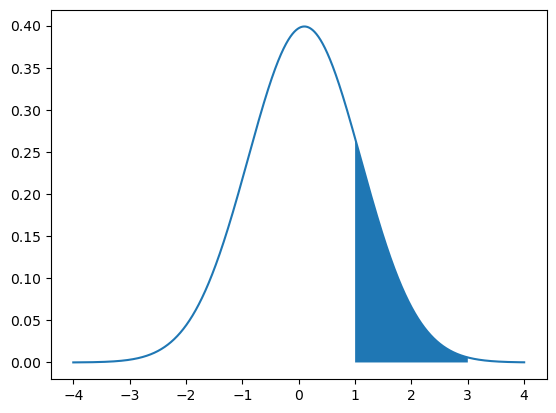

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.integrate as integrate

distribution_function = lambda x: norm.pdf(x, 0.1)
x1 = 1
x2 = 3

print('probability to fall between {0} and {1} :'.format(x1, x2), integrate.quad(distribution_function, x1, x2)[0])
step = 0.001
whole_x = np.arange(-4, 4, step)
whole_y = list(map(distribution_function, whole_x))

needed_x = np.arange(x1, x2, step)
needed_y = list(map(distribution_function, needed_x))
plt.plot(whole_x, whole_y)
plt.fill_between(needed_x, needed_y)

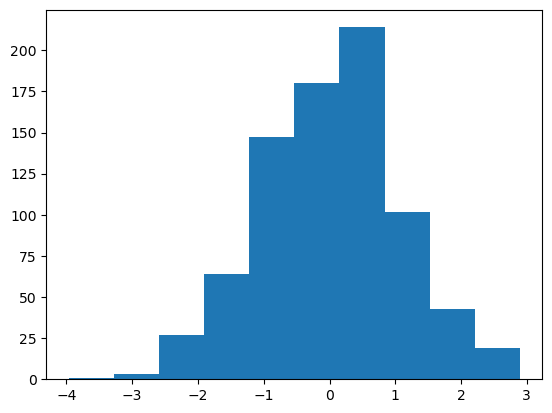

In [2]:
# example of plotting a histogram of a random sample
from matplotlib import pyplot
from numpy.random import normal
# generate a sample
sample = normal(size=800)
# plot a histogram of the sample
pyplot.hist(sample, bins=10)
# Running with bins = 3, to make it less obvious
#pyplot.hist(sample, bins=3)
pyplot.show()

Mean=49.969, Standard Deviation=5.060


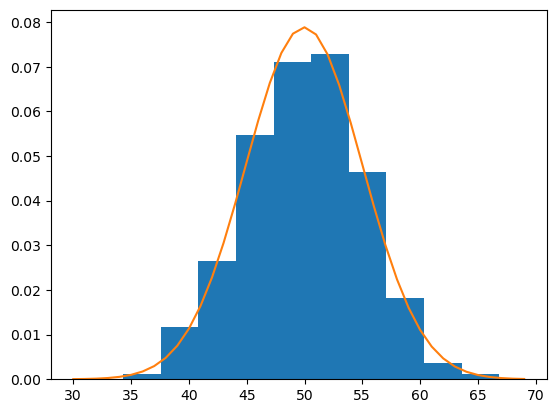

In [3]:
from matplotlib import pyplot
from numpy.random import normal
from numpy import mean
from numpy import std
from scipy.stats import norm
# generate a sample
sample = normal(loc=50, scale=5, size=1000)
# calculate parameters
sample_mean = mean(sample)
sample_std = std(sample)
print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_std))
# define the distribution
dist = norm(sample_mean, sample_std)
# sample probabilities for a range of outcomes
values = [value for value in range(30, 70)]
probabilities = [dist.pdf(value) for value in values]
# plot the histogram and pdf
pyplot.hist(sample, bins=10, density=True)
pyplot.plot(values, probabilities)
pyplot.show()

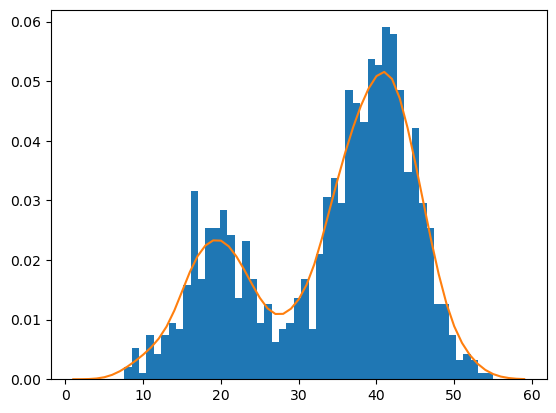

In [4]:
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
# generate a sample
sample1 = normal(loc=20, scale=5, size=300)
sample2 = normal(loc=40, scale=5, size=700)
sample = hstack((sample1, sample2))
# fit density
model = KernelDensity(bandwidth=2, kernel='gaussian')
sample = sample.reshape((len(sample), 1))
model.fit(sample)
# sample probabilities for a range of outcomes
values = asarray([value for value in range(1, 60)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = exp(probabilities)
# plot the histogram and pdf
pyplot.hist(sample, bins=50, density=True)
pyplot.plot(values[:], probabilities)
pyplot.show()

# Introduction to data science 
A basic rubric for the early stages of exploratory data analysis in Python. This isn't universally applicable, but it does cover many patterns which recur in several data analysis contexts. It's useful to keep this rubric in mind when encountering a new dataset.

The basic workflow is as follows:

Build a DataFrame from the data (ideally, put all data in this object)
Clean the DataFrame. It should have the following properties:
- Each row describes a single object
- Each column describes a property of that object
- Columns are numeric whenever appropriate
- Columns contain atomic properties that cannot be further decomposed
- Explore global properties. Use histograms, scatter plots, and aggregation functions to summarize the data.
- Explore group properties. Use groupby and small multiples to compare subsets of the data.
This process transforms your data into a format which is easier to work with, gives you a basic overview of the data's properties, and likely generates several questions for you to followup in subsequent analysis.

Here's a preview of the raw data we'll use -- it's a list of the 10,000 movies made since 1950 with the most IMDB user ratings. It was scraped about a year ago from pages like this. Download the data at http://bit.ly/cs109_imdb.

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#tell pandas to display wide tables as pretty HTML tables
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [6]:
!head imdb_top_10000.txt

'head' is not recognized as an internal or external command,
operable program or batch file.


# 1. Build a DataFrame
The textfile is tab-separated, and doesn't have any column headers. We set the appropriate keywords in pd.read_csv to handle this

In [7]:
names = ['imdbID', 'title', 'year', 'score', 'votes', 'runtime', 'genres']
data = pd.read_csv('imdb_top_10000.txt', delimiter='\t', names=names).dropna()
print ("Number of rows: %i" % data.shape[0])
data.head()  # print the first 5 rows

Number of rows: 9999


,imdbID,title,year,score,votes,runtime,genres
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142 mins.,Crime|Drama
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154 mins.,Crime|Thriller
2,tt0137523,Fight Club (1999),1999,8.8,458173,139 mins.,Drama|Mystery|Thriller
3,tt0133093,The Matrix (1999),1999,8.7,448114,136 mins.,Action|Adventure|Sci-Fi
4,tt1375666,Inception (2010),2010,8.9,385149,148 mins.,Action|Adventure|Sci-Fi|Thriller


# 2. Clean the DataFrame
There are several problems with the DataFrame at this point:

- The runtime column describes a number, but is stored as a string
- The genres column is not atomic -- it aggregates several genres together. This makes it hard, for example, to extract which movies are Comedies.
- The movie year is repeated in the title and year column
- Fixing the runtime column
- The following snipptet converts a string like '142 mins.' to the number 142:

In [8]:
dirty = '142 mins.'
number, text = dirty.split(' ')
clean = int(number)
print (number)
print (clean)
type(number)
type(clean)

142
142


int

We can package this up into a list comprehension

In [9]:
clean_runtime = [float(r.split(' ')[0]) for r in data.runtime]
data['runtime'] = clean_runtime
data.head()

,imdbID,title,year,score,votes,runtime,genres
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142.0,Crime|Drama
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154.0,Crime|Thriller
2,tt0137523,Fight Club (1999),1999,8.8,458173,139.0,Drama|Mystery|Thriller
3,tt0133093,The Matrix (1999),1999,8.7,448114,136.0,Action|Adventure|Sci-Fi
4,tt1375666,Inception (2010),2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller


# Splitting up the genres

We can use the concept of indicator variables to split the genres column into many columns. Each new column will correspond to a single genre, and each cell will be True or False.

In [10]:
#determine the unique genres
genres = set()
for m in data.genres:
    genres.update(g for g in m.split('|'))
genres = sorted(genres)

#make a column for each genre
for genre in genres:
    data[genre] = [genre in movie.split('|') for movie in data.genres]
         
data.head()

,imdbID,title,year,score,votes,runtime,genres,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0111161,The Shawshank Redemption (1994),1994,9.2,619479,142.0,Crime|Drama,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0110912,Pulp Fiction (1994),1994,9.0,490065,154.0,Crime|Thriller,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,tt0137523,Fight Club (1999),1999,8.8,458173,139.0,Drama|Mystery|Thriller,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
3,tt0133093,The Matrix (1999),1999,8.7,448114,136.0,Action|Adventure|Sci-Fi,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,tt1375666,Inception (2010),2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False


# Removing year from the title
We can fix each element by stripping off the last 7 characters

In [11]:
data['title'] = [t[0:-7] for t in data.title]
data.head()

,imdbID,title,year,score,votes,runtime,genres,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0111161,The Shawshank Redemption,1994,9.2,619479,142.0,Crime|Drama,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0110912,Pulp Fiction,1994,9.0,490065,154.0,Crime|Thriller,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,tt0137523,Fight Club,1999,8.8,458173,139.0,Drama|Mystery|Thriller,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
3,tt0133093,The Matrix,1999,8.7,448114,136.0,Action|Adventure|Sci-Fi,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,tt1375666,Inception,2010,8.9,385149,148.0,Action|Adventure|Sci-Fi|Thriller,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False


# 3. Explore global properties
Next, we get a handle on some basic, global summaries of the DataFrame.

Call describe on relevant columns

In [12]:
data[['score', 'runtime', 'year', 'votes']].describe()

,score,runtime,year,votes
count,9999.000000,9999.000000,9999.000000,9999.000000
mean,6.385989,103.580358,1993.471447,16605.462946
std,1.189965,26.629310,14.830049,34564.883945
min,1.500000,0.000000,1950.000000,1356.000000
25%,5.700000,93.000000,1986.000000,2334.500000
50%,6.600000,102.000000,1998.000000,4981.000000
75%,7.200000,115.000000,2005.000000,15278.500000
max,9.200000,450.000000,2011.000000,619479.000000


In [13]:
#hmmm, a runtime of 0 looks suspicious. How many movies have that?
print (len(data[data.runtime == 0]))

#probably best to flag those bad data as NAN
data.runtime[data.runtime==0] = np.nan

282


C:\Users\jovan\AppData\Local\Temp\ipykernel_3672\2281657464.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.runtime[data.runtime==0] = np.nan


After flagging bad runtimes, we repeat

In [14]:
data.runtime.describe()

count    9717.000000
mean      106.586395
std        20.230330
min        45.000000
25%        93.000000
50%       103.000000
75%       115.000000
max       450.000000
Name: runtime, dtype: float64

# Make some basic plots


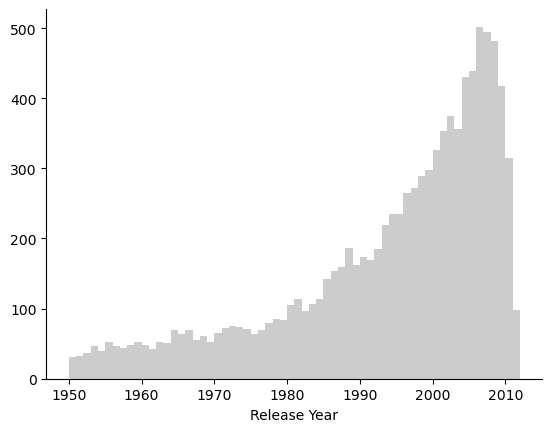

In [15]:
# more movies in recent years, but not *very* recent movies (they haven't had time to receive lots of votes yet?)
plt.hist(data.year, bins=np.arange(1950, 2013), color='#cccccc')
plt.xlabel("Release Year")
remove_border()

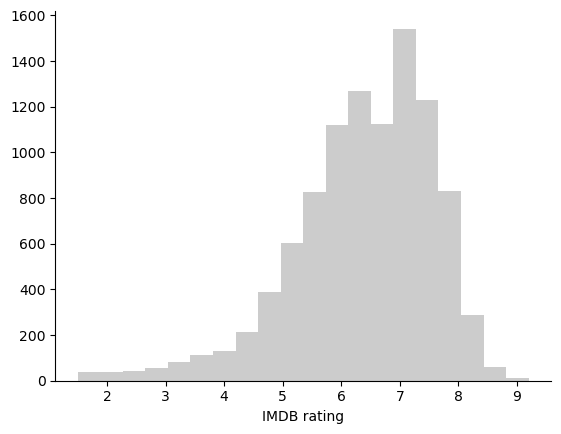

In [16]:
plt.hist(data.score, bins=20, color='#cccccc')
plt.xlabel("IMDB rating")
remove_border()

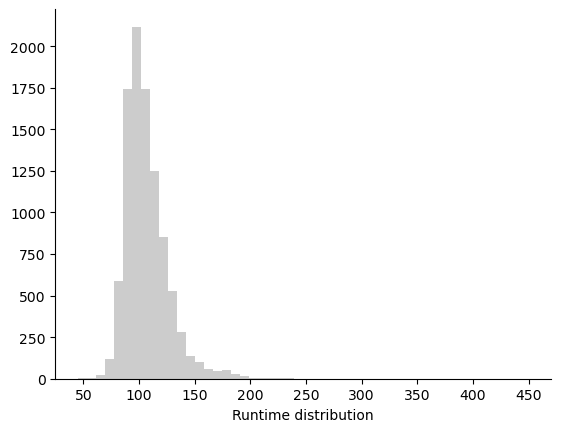

In [17]:
plt.hist(data.runtime.dropna(), bins=50, color='#cccccc')
plt.xlabel("Runtime distribution")
remove_border()

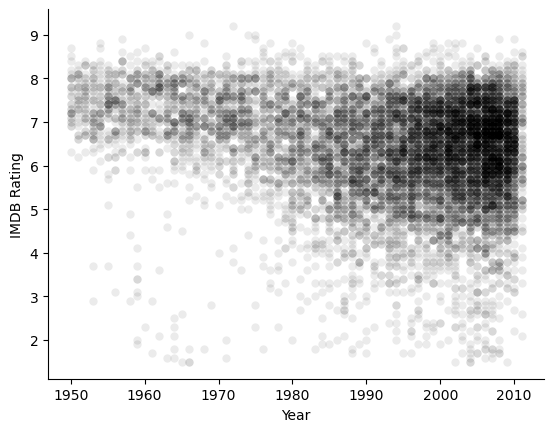

In [18]:
#hmm, more bad, recent movies. Real, or a selection bias?

plt.scatter(data.year, data.score, lw=0, alpha=.08, color='k')
plt.xlabel("Year")
plt.ylabel("IMDB Rating")
remove_border()

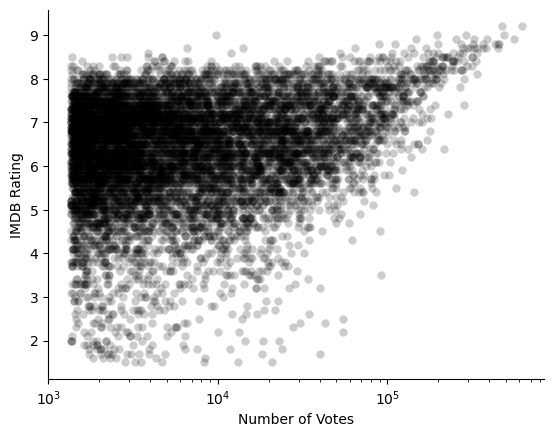

In [19]:
plt.scatter(data.votes, data.score, lw=0, alpha=.2, color='k')
plt.xlabel("Number of Votes")
plt.ylabel("IMDB Rating")
plt.xscale('log')
remove_border()

# Identify some outliers

In [20]:
# low-score movies with lots of votes
data[(data.votes > 9e4) & (data.score < 5)][['title', 'year', 'score', 'votes', 'genres']]

,title,year,score,votes,genres
317,New Moon,2009,4.5,90457,Adventure|Drama|Fantasy|Romance
334,Batman & Robin,1997,3.5,91875,Action|Crime|Fantasy|Sci-Fi


In [21]:
# The lowest rated movies
data[data.score == data.score.min()][['title', 'year', 'score', 'votes', 'genres']]

,title,year,score,votes,genres
1982,Manos: The Hands of Fate,1966,1.5,20927,Horror
2793,Superbabies: Baby Geniuses 2,2004,1.5,13196,Comedy|Family
3746,Daniel the Wizard,2004,1.5,8271,Comedy|Crime|Family|Fantasy|Horror
5158,Ben & Arthur,2002,1.5,4675,Drama|Romance
5993,Night Train to Mundo Fine,1966,1.5,3542,Action|Adventure|Crime|War
6257,Monster a-Go Go,1965,1.5,3255,Sci-Fi|Horror
6726,Dream Well,2009,1.5,2848,Comedy|Romance|Sport


In [22]:
# The highest rated movies
data[data.score == data.score.max()][['title', 'year', 'score', 'votes', 'genres']]

,title,year,score,votes,genres
0,The Shawshank Redemption,1994,9.2,619479,Crime|Drama
26,The Godfather,1972,9.2,474189,Crime|Drama


# Run aggregation functions like sum over several rows or columns - Homework
What genres are the most frequent?

The most frequent genre is Drama with 5697 entries


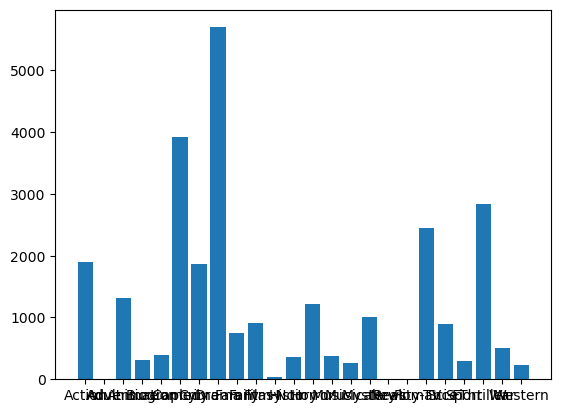

In [23]:
# Your solution

genres = set()
for m in data.genres:
    genres.update(g for g in m.split('|'))
genres = sorted(genres)

for genre in genres:
    data[genre] = [genre in movie.split('|') for movie in data.genres]

genres_list = []
numbers_list = []
for genre in genres:
    genres_list.append(genre)
    numbers_list.append(data[genre].sum())

index = numbers_list.index(max(numbers_list))
print(f'The most frequent genre is {genres_list[index]} with {max(numbers_list)} entries')

plt.bar(genres_list, numbers_list)
plt.show()

# Explore Group Properties
Let's split up movies by decade

GroupBy will gather movies into groups with equal decade values

In [24]:
decade =  (data.year // 10) * 10

tyd = data[['title', 'year']]
tyd['decade'] = decade

tyd.head()

C:\Users\jovan\AppData\Local\Temp\ipykernel_3672\3039315050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tyd['decade'] = decade


,title,year,decade
0,The Shawshank Redemption,1994,1990
1,Pulp Fiction,1994,1990
2,Fight Club,1999,1990
3,The Matrix,1999,1990
4,Inception,2010,2010


year
1950    7.244522
1960    7.062367
1970    6.842297
1980    6.248693
1990    6.199316
2000    6.277858
2010    6.344552
Name: Decade Mean, dtype: float64


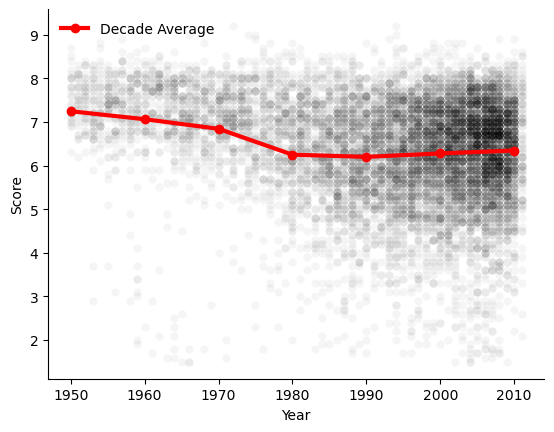

In [25]:
#mean score for all movies in each decade
decade_mean = data.groupby(decade).score.mean()
decade_mean.name = 'Decade Mean'
print (decade_mean)

plt.plot(decade_mean.index, decade_mean.values, 'o-',
        color='r', lw=3, label='Decade Average')
plt.scatter(data.year, data.score, alpha=.04, lw=0, color='k')
plt.xlabel("Year")
plt.ylabel("Score")
plt.legend(frameon=False)
remove_border()

We can go one further, and compute the scatter in each year as well

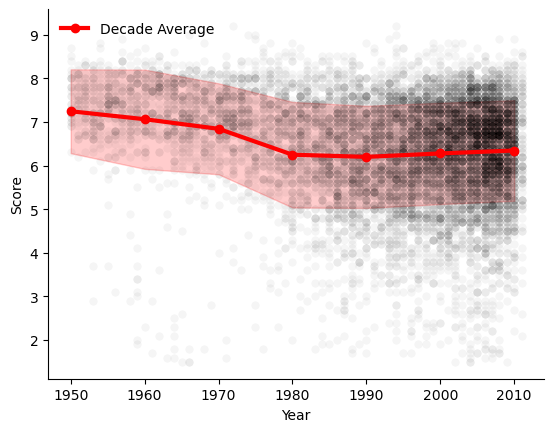

In [26]:
grouped_scores = data.groupby(decade).score

mean = grouped_scores.mean()
std = grouped_scores.std()

plt.plot(decade_mean.index, decade_mean.values, 'o-',
        color='r', lw=3, label='Decade Average')
plt.fill_between(decade_mean.index, (decade_mean + std).values,
                 (decade_mean - std).values, color='r', alpha=.2)
plt.scatter(data.year, data.score, alpha=.04, lw=0, color='k')
plt.xlabel("Year")
plt.ylabel("Score")
plt.legend(frameon=False)
remove_border()

You can also iterate over a GroupBy object. 

Each iteration yields two variables: one of the distinct values of the group key, and the subset of the dataframe where the key equals that value. To find the most popular movie each year:

In [27]:
for year, subset in data.groupby('year'):
    print (year, subset[subset.score == subset.score.max()].title.values)

1950 ['Sunset Blvd.']
1951 ['Strangers on a Train']
1952 ["Singin' in the Rain"]
1953 ['The Wages of Fear' 'Tokyo Story']
1954 ['Seven Samurai']
1955 ['Diabolique']
1956 ['The Killing']
1957 ['12 Angry Men']
1958 ['Vertigo']
1959 ['North by Northwest']
1960 ['Psycho']
1961 ['Yojimbo']
1962 ['To Kill a Mockingbird' 'Lawrence of Arabia']
1963 ['The Great Escape' 'High and Low']
1964 ['Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb']
1965 ['For a Few Dollars More']
1966 ['The Good, the Bad and the Ugly']
1967 ['Cool Hand Luke']
1968 ['Once Upon a Time in the West']
1969 ['Butch Cassidy and the Sundance Kid' 'Army of Shadows']
1970 ['Patton' 'The Conformist' 'Le Cercle Rouge']
1971 ['A Clockwork Orange']
1972 ['The Godfather']
1973 ['The Sting' 'Scenes from a Marriage']
1974 ['The Godfather: Part II']
1975 ['Outrageous Class']
1976 ['Tosun Pasa']
1977 ['Star Wars: Episode IV - A New Hope']
1978 ['The Girl with the Red Scarf']
1979 ['Apocalypse Now']
1980 ['Star Wars: 

# Small multiples
Let's split up the movies by genre, and look at how their release year/runtime/IMDB score vary. The distribution for all movies is shown as a grey background.

This isn't a standard groupby, so we can't use the groupby method here. A manual loop is needed

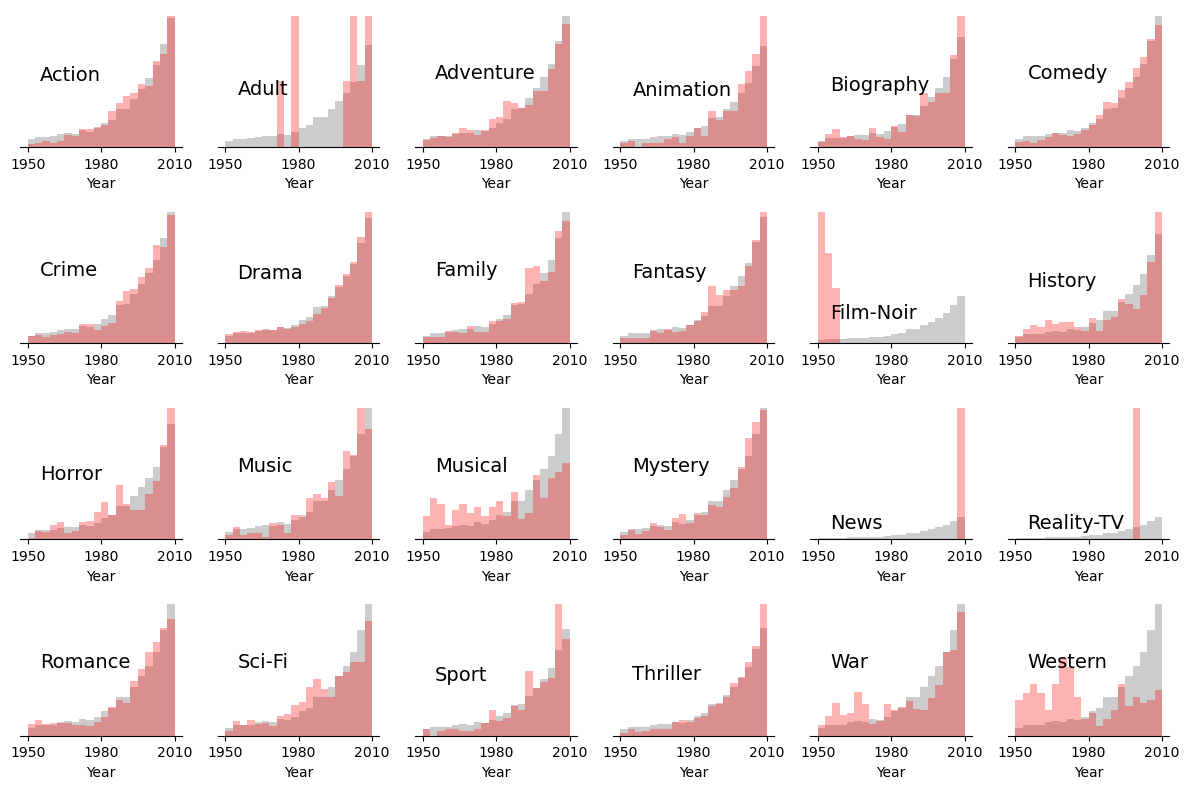

In [28]:
#create a 4x6 grid of plots.
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), 
                         tight_layout=True)

bins = np.arange(1950, 2013, 3)
for ax, genre in zip(axes.ravel(), genres):
    ax.hist(data[data[genre] == 1].year, 
            bins=bins, histtype='stepfilled', color='r', alpha=.3, ec='none', density=True)
    ax.hist(data.year, bins=bins, histtype='stepfilled', ec='None', zorder=0, color='#cccccc', density=True)
    
    ax.annotate(genre, xy=(1955, 3e-2), fontsize=14)
    ax.xaxis.set_ticks(np.arange(1950, 2013, 30))
    ax.set_yticks([])
    remove_border(ax, left=False)
    ax.set_xlabel('Year')

Some subtler patterns here:

Westerns and Musicals have a more level distribution

Film Noir movies were much more popular in the 50s and 60s

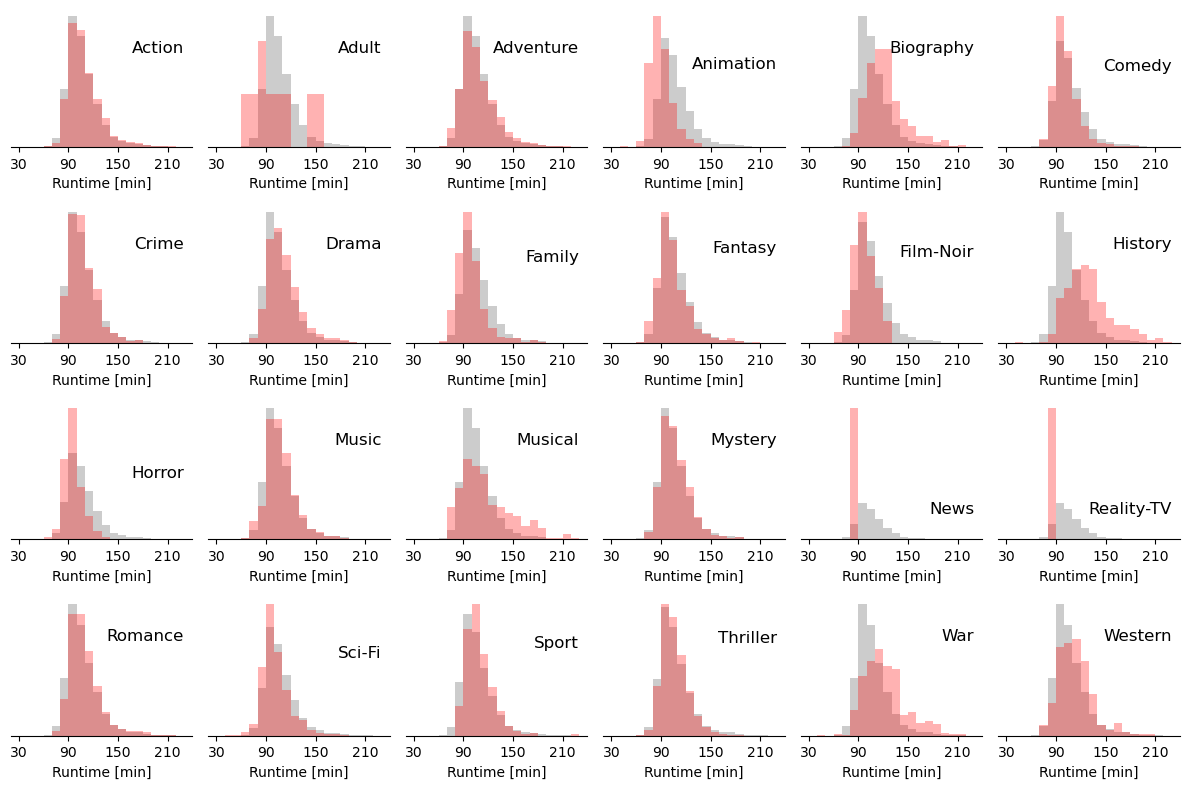

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), tight_layout=True)

bins = np.arange(30, 240, 10)

for ax, genre in zip(axes.ravel(), genres):
    ax.hist(data[data[genre] == 1].runtime, 
            bins=bins, histtype='stepfilled', color='r', ec='none', alpha=.3, density=True)
               
    ax.hist(data.runtime, bins=bins, density=True,
            histtype='stepfilled', ec='none', color='#cccccc',
            zorder=0)
    
    ax.set_xticks(np.arange(30, 240, 60))
    ax.set_yticks([])
    ax.set_xlabel("Runtime [min]")
    remove_border(ax, left=False)
    ax.annotate(genre, xy=(230, .02), ha='right', fontsize=12)

1. Biographies and history movies are longer
2. Animated movies are shorter
3. Film-Noir movies have the same mean, but are more conentrated around a 100 minute runtime
4. Musicals have the same mean, but greater dispersion in runtimes

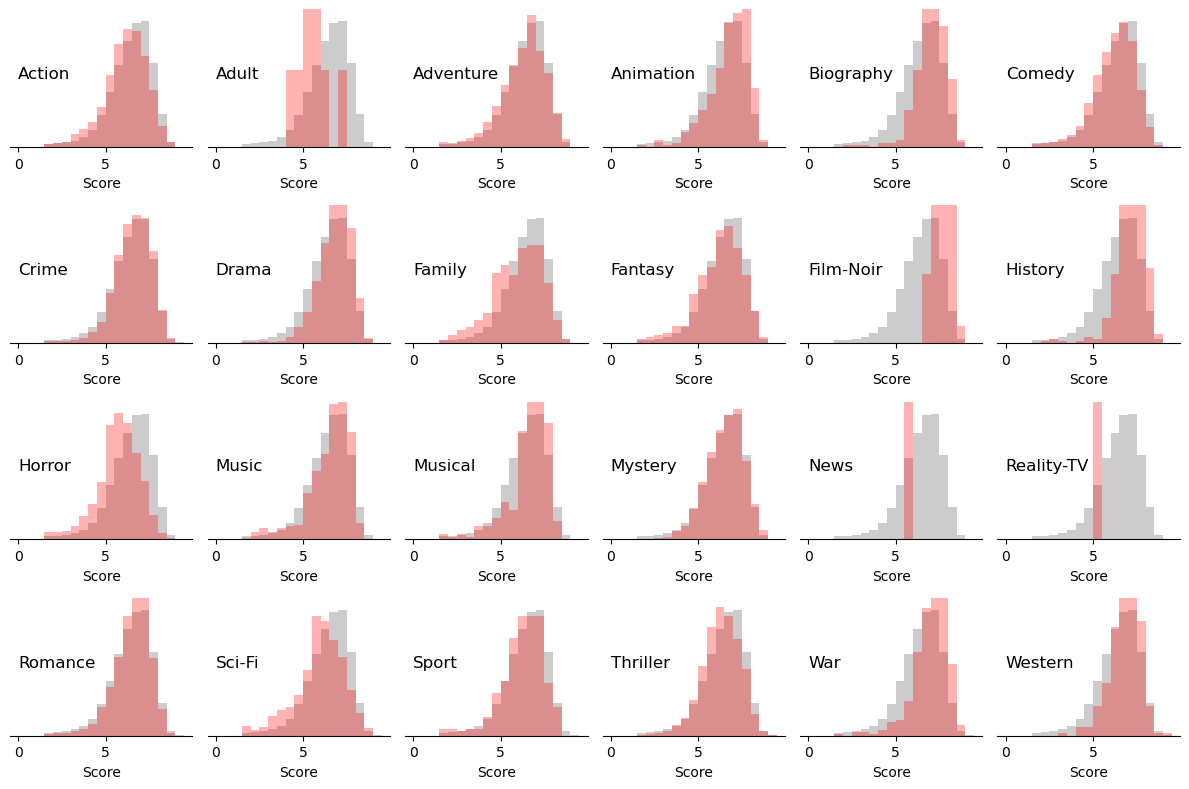

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 8), tight_layout=True)

bins = np.arange(0, 10, .5)

for ax, genre in zip(axes.ravel(), genres):
    ax.hist(data[data[genre] == 1].score, 
            bins=bins, histtype='stepfilled', color='r', ec='none', alpha=.3, density=True)
               
    ax.hist(data.score, bins=bins, density=True,
            histtype='stepfilled', ec='none', color='#cccccc',
            zorder=0)
    
    ax.set_yticks([])
    ax.set_xlabel("Score")
    remove_border(ax, left=False)
    ax.set_ylim(0, .4)
    ax.annotate(genre, xy=(0, .2), ha='left', fontsize=12)


1. Film-noirs, histories, and biographies have higher ratings (a selection effect?)
2. Horror movies and adult films have lower ratings


# Homework: 
Write a short report desribing (and showcasing proof) to which 3 properties (i.e. which type, number of user votes,...) does a movie need to have (and the desired amount/quantity) in order to be considered an Oscar candidate (defined by Score > 8.5).

C:\Users\jovan\AppData\Local\Temp\ipykernel_3672\2676611335.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oscars[genre] = [genre in movie.split('|') for movie in oscars.genres]


The most frequent genre is Drama with 29 entries


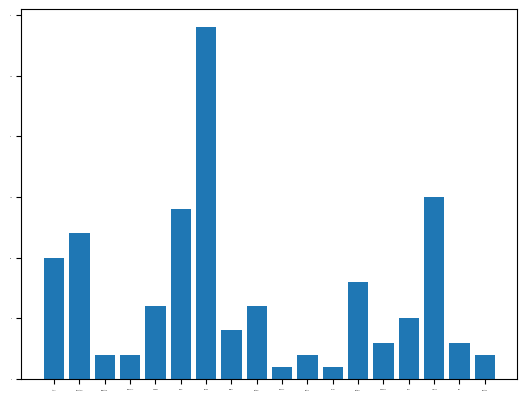

,year,score,votes,runtime
count,46.000000,46.000000,46.00000,46.000000
mean,1985.065217,8.760870,254670.73913,133.282609
std,17.550438,0.157025,156257.88601,32.046954
min,1950.000000,8.600000,3868.00000,86.000000
25%,1974.250000,8.600000,139297.25000,110.500000
50%,1991.000000,8.700000,270405.00000,126.000000
75%,1999.000000,8.800000,357741.25000,151.000000
max,2011.000000,9.200000,619479.00000,207.000000


In [33]:
oscars = data[data.score > 8.5]

genres = set()
for m in oscars.genres:
    genres.update(g for g in m.split('|'))
genres = sorted(genres)

for genre in genres:
    oscars[genre] = [genre in movie.split('|') for movie in oscars.genres]

genres_list = []
numbers_list = []
for genre in genres:
    genres_list.append(genre)
    numbers_list.append(oscars[genre].sum())

index = numbers_list.index(max(numbers_list))
print(f'The most frequent genre is {genres_list[index]} with {max(numbers_list)} entries')

plt.bar(genres_list, numbers_list)
plt.rcParams['font.size'] = 1
plt.show()

oscars.describe()


In [32]:
'''
When data is filtered, the best discriminatory property is the one with the smallest standard deviation compared to the range of values. Scores are the following:
year: 0.29
votes: 0.25
runtime: 0.26
It seems that all three properties are somewhat simillarly important with votes being the best. It can also be seen that movie falling under drama genre helps.
'''

'\nWhen data is filtered, the best discriminatory property is the one with the smallest standard deviation compared to the range of values. Scores are the following:\nyear: 0.29\nvotes: 0.25\nruntime: 0.26\nIt seems that all three properties are somewhat simillarly important with votes being the best. It can also be seen that movie falling under drama genre helps.\n'